In [120]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statistics
from sklearn.linear_model import LinearRegression
import os
import sqlite3

In [122]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In [123]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')

In [124]:
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [125]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)
data['Year'] = data['Year'].astype(int)
data['banking_crisis'] = pd.to_numeric(data['banking_crisis'], errors='coerce')
data['systemic_crisis'] = pd.to_numeric(data['systemic_crisis'], errors='coerce')
data['annual_inflation'] = pd.to_numeric(data['annual_inflation'], errors='coerce')

In [126]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)
GDP_pc.dtypes

Entity             object
Code               object
Year                int64
GDP_per_capita    float64
dtype: object

# 1. Selecting countries for global analysis

In [337]:
def create_output_df(data, code):
    df = data.loc[data['Code'] == code]
    cycle, trend = sm.tsa.filters.hpfilter(df.GDP_per_capita, lamb=1600)
    dataframe = pd.DataFrame({
    'CC3': df.Code,
    'Year' : df.Year,
    'output_gap' : round(((df.GDP_per_capita - trend)/trend)*100, 2)})
    return dataframe

def merge_datasets(dataset1, dataset2, on=['Year', 'CC3'], how='left'):
    merged_df = pd.merge(dataset1, dataset2, on=on, how=how)
    return merged_df

def concat_dataset(dataset1, dataset2, list, how):
    all_datasets = []
    for code in list:
        df = merge_datasets(dataset2[dataset2["CC3"]==code], create_output_df(dataset1, code), how = how)
        all_datasets.append(df)

    concat_dataset = pd.concat(all_datasets,ignore_index=True)
    return concat_dataset

In [570]:
countries_selected = ['FRA',
                      'GBR',
                      'USA',
                      'ITA',
                      'DEU',
                      'CAN',
                    #   'JPN',
                      'ESP',
                      'NLD',
                      'DNK',
                      'SWE',
                      'BEL',
                      'NOR',
                      'PRT',
                      'FIN',
                      'AUT',
                      ]

In [571]:
global_data = concat_dataset(GDP_pc, data, countries_selected, 'left')
global_data

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,sovereign_external_debt_1,sovereign_external_debt_2,Defaults_External_Notes,GDP_Weighted_default,<,annual_inflation,Independence,Currency Crises,Inflation Crises,output_gap
0,22.0,FRA,France,1800,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.9,1,0,0,NaN
1,22.0,FRA,France,1801,0.0,NaN,0.0,0,0.007935276,0.052052,...,0,0.0,NaN,0,NaN,-11.0,1,0,0,NaN
2,22.0,FRA,France,1802,1.0,Bank of France: serious crisis.,1.0,0,0.006923777,0.045417,...,0,0.0,NaN,0,NaN,-1.0,1,0,0,NaN
3,22.0,FRA,France,1803,0.0,NaN,0.0,0,0.006877737,0.045115,...,0,0.0,NaN,0,NaN,6.7,1,0,0,NaN
4,22.0,FRA,France,1804,0.0,NaN,0.0,0,0.007290569,0.047823,...,0,0.0,NaN,0,NaN,-6.3,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,5.0,AUT,Austria,2012,0.0,NaN,0.0,0,0.76,NaN,...,0,0.0,NaN,0,0,2.6,1,0,0,1.47
3251,5.0,AUT,Austria,2013,0.0,NaN,0.0,0,0.73,NaN,...,0,0.0,NaN,0,0,2.1,1,0,0,-0.15
3252,5.0,AUT,Austria,2014,0.0,NaN,0.0,0,0.82,NaN,...,0,0.0,NaN,0,0,1.5,1,0,0,-1.34
3253,5.0,AUT,Austria,2015,NaN,NaN,NaN,0,0.90,NaN,...,0,0.0,NaN,0,0,0.8,1,0,0,-2.52


In [572]:
banking_crisis_years = global_data[global_data['banking_crisis'] == 1]['Year'].tolist()
banking_crisis_first_year = [banking_crisis_years[0]]
for i in range (1, len(banking_crisis_years)):
    if banking_crisis_years[i]-banking_crisis_years[i-1] >=2 or banking_crisis_years[i]-banking_crisis_years[i-1]<0:
        banking_crisis_first_year.append(banking_crisis_years[i])
print(f'In this aproch, we record {len(banking_crisis_first_year)} different crisis event.')
banking_crisis_first_year[40:]

In this aproch, we record 132 different crisis event.


[1929,
 1984,
 2007,
 1866,
 1889,
 1891,
 1893,
 1907,
 1914,
 1921,
 1930,
 1935,
 1990,
 2008,
 1857,
 1880,
 1901,
 1929,
 1977,
 2008,
 1838,
 1866,
 1873,
 1906,
 1912,
 1923,
 1983,
 1814,
 1829,
 1846,
 1920,
 1931,
 1977,
 2008,
 1819,
 1897,
 1914,
 1921,
 1939,
 2008,
 1813,
 1857,
 1877,
 1885,
 1902,
 1907,
 1914,
 1921,
 1931,
 1987,
 2008,
 1811,
 1876,
 1897,
 1907,
 1922,
 1931,
 1991,
 2008,
 1838,
 1842,
 1848,
 1870,
 1914,
 1925,
 1931,
 1934,
 1939,
 2008,
 1814,
 1899,
 1921,
 1927,
 1936,
 1987,
 1828,
 1846,
 1890,
 1920,
 1923,
 1931,
 2008,
 1900,
 1921,
 1931,
 1939,
 1991,
 1873,
 1924,
 1929,
 1931,
 2008]

In [573]:
crisis_duration = []
current_length = 0

for value in global_data['banking_crisis']:
    if value == 1:
        current_length += 1
    elif current_length > 0:
        crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)
print(len(crisis_duration))

[1, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 7, 1, 4, 2, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 8, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 4, 3, 1, 1, 1, 1, 1, 2, 2, 1, 6, 7, 1, 1, 1, 4, 3, 3, 2, 1, 1, 2, 1, 1, 3, 4, 1, 2, 6, 1, 9, 7, 11, 1, 1, 2, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 7, 4, 4, 1, 1, 2, 2, 4, 3, 2, 1, 1, 2, 1, 2, 1, 1, 1, 7, 1, 2, 3, 1, 1, 7, 1, 2, 1, 1, 1, 2, 7, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4]
132


In [574]:
length_counts = {}
for length in crisis_duration:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1

# Convert dictionary to pandas DataFrame
len_freq = pd.DataFrame(list(length_counts.items()), columns=['Length', 'Count'])

# Sort DataFrame by length
len_freq = len_freq.sort_values(by='Length')
len_freq.reset_index(drop=True, inplace=True)
print(len_freq)
print(sum(len_freq.Count))

   Length  Count
0       1     72
1       2     25
2       3     10
3       4      9
4       5      1
5       6      3
6       7      8
7       8      2
8       9      1
9      11      1
132


# 2. Extracting inflation series

In [575]:
def extract_inflation_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'annual_inflation']
    return np.array(series)

def years_xaxis(length):
    years = []
    for i in range (-1,length):
        if i<0:
            years.append(f"t{i}")
        elif i==0:
            years.append(f"t")
        else:
            years.append(f"t+{i}")
    return years


In [576]:
inflation_series = []
for year in banking_crisis_first_year:
    series_for_year = extract_inflation_series(global_data, year)
    inflation_series.append(series_for_year)
inflation_series = np.array(inflation_series)

In [577]:
norm_inflation_series = []
for array in inflation_series:
    norm_inflation_series.append(array - array[0])
norm_inflation_series = np.array(norm_inflation_series)
len(norm_inflation_series)

132

## 2.1 Inflation response to each year of crisis

72


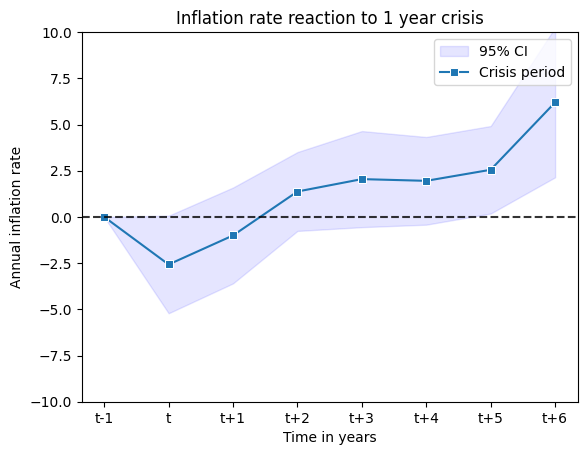

25


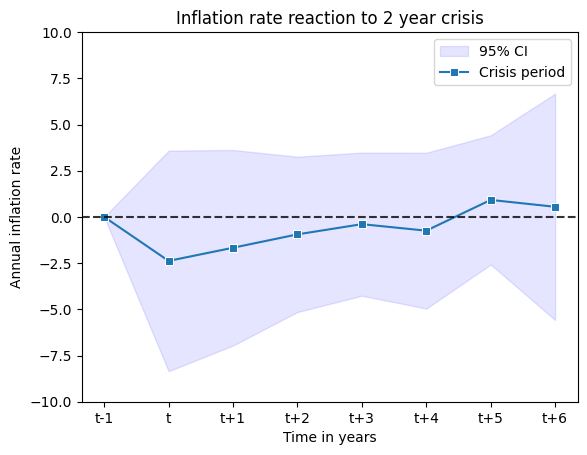

10


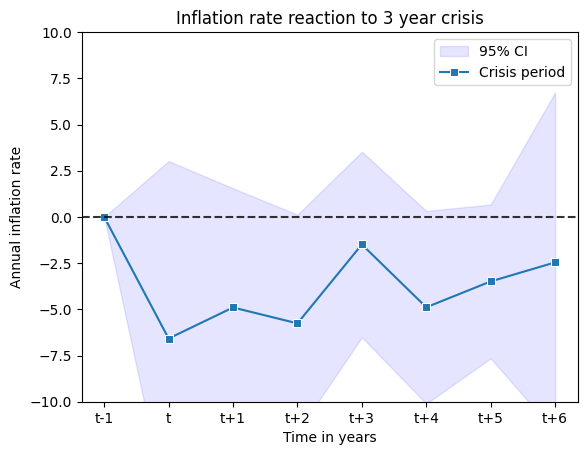

9


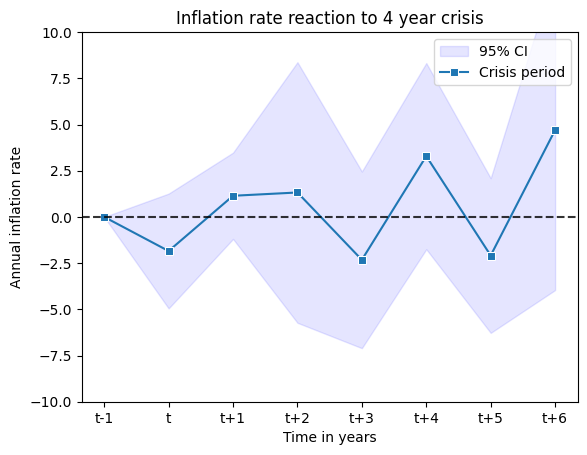

1


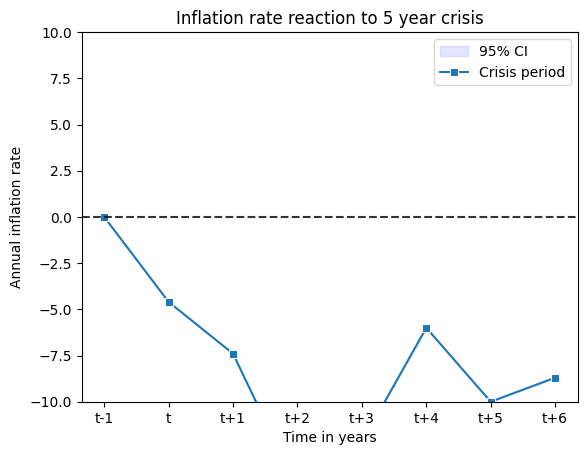

3


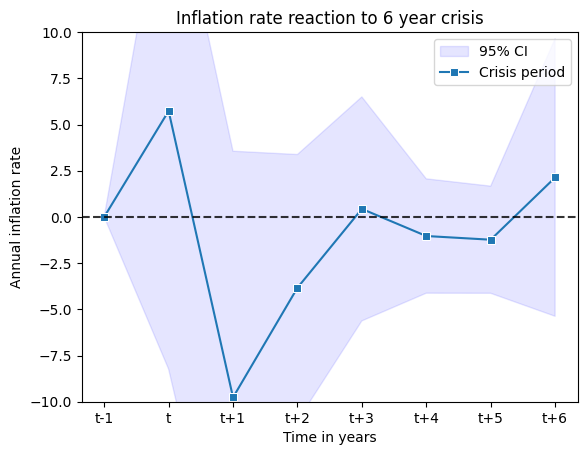

8


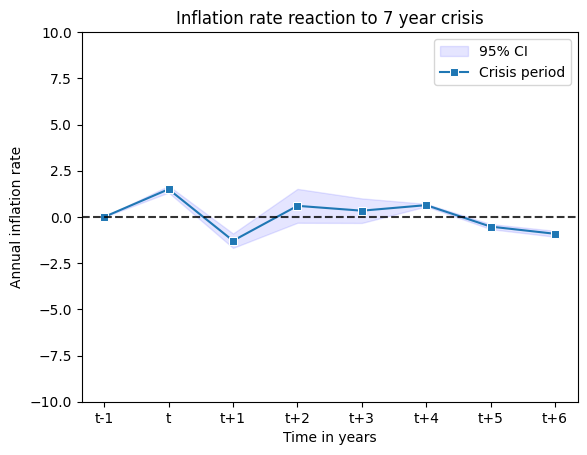

2


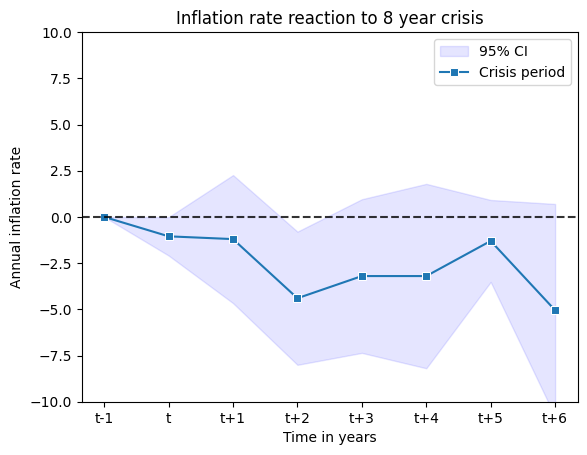

1


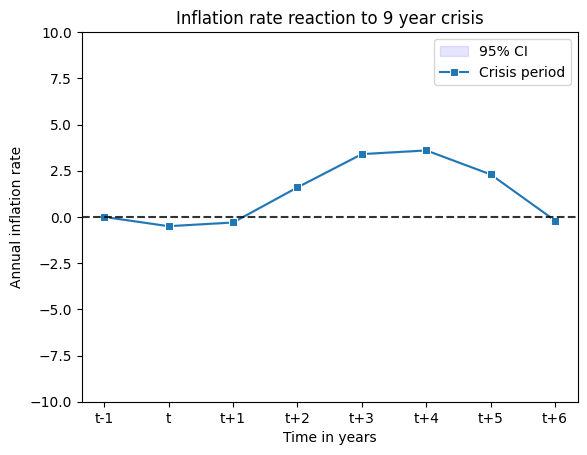

1


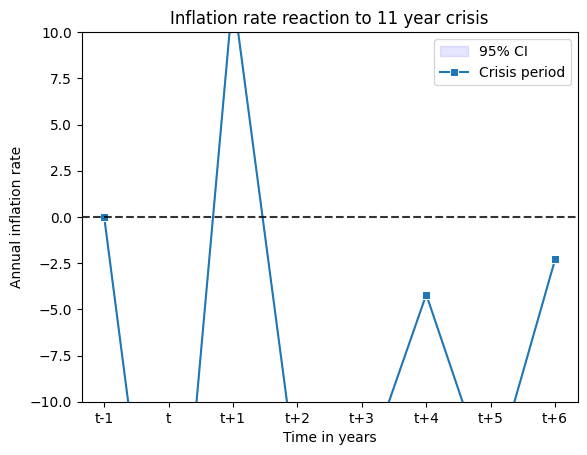

In [578]:
for i in len_freq.Length:
    series_by_crisis_length = []
    #Appending the series for single year crisis
    for j in range (0,len(norm_inflation_series)):
        if crisis_duration[j] == i:
            series_by_crisis_length.append(norm_inflation_series[j])
    series_by_crisis_length = np.array(series_by_crisis_length)
    print(len(series_by_crisis_length))

    average_pattern = np.mean(series_by_crisis_length, axis=0)
    confidence_interval = 1.96 * np.std(series_by_crisis_length, axis=0) / np.sqrt(series_by_crisis_length.shape[0])

    years = [f"t{k}" if k < 0 else f"t+{k}" if k > 0 else "t" for k in range(-1, len(average_pattern) - 1)]

    plt.fill_between(
        range(len(average_pattern)),
        average_pattern - confidence_interval,
        average_pattern + confidence_interval,
        color='blue',
        alpha=0.1, label='95% CI'
    )

    sns.lineplot(x = years, y = average_pattern, marker = 's', label = 'Crisis period')
    plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.8)

    plt.title(f'Inflation rate reaction to {i} year crisis')

    plt.xlabel('Time in years')
    plt.ylabel('Annual inflation rate')
    plt.ylim(-10,10)

    plt.show()

# 3. Extracting output gap series

In [579]:
global_data_inner = concat_dataset(GDP_pc, data, countries_selected, 'inner')
global_data_inner

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,sovereign_external_debt_1,sovereign_external_debt_2,Defaults_External_Notes,GDP_Weighted_default,<,annual_inflation,Independence,Currency Crises,Inflation Crises,output_gap
0,22.0,FRA,France,1820,0.0,NaN,0.0,0,0.008460006,0.055494,...,0,0.0,NaN,0,0,21.7,1,0,1,-1.68
1,22.0,FRA,France,1821,0.0,NaN,0.0,0,0.007927654,0.052002,...,0,0.0,NaN,0,0,-4.7,1,0,0,5.42
2,22.0,FRA,France,1822,0.0,NaN,0.0,0,0.007944118,0.052110,...,0,0.0,NaN,0,0,-4.6,1,0,0,0.49
3,22.0,FRA,France,1823,0.0,NaN,0.0,0,0.008134984,0.053362,...,0,0.0,NaN,0,0,5.4,1,0,0,2.91
4,22.0,FRA,France,1824,0.0,NaN,0.0,0,0.007886645,0.051733,...,0,0.0,NaN,0,0,-4.9,1,0,0,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,5.0,AUT,Austria,2012,0.0,NaN,0.0,0,0.76,NaN,...,0,0.0,NaN,0,0,2.6,1,0,0,1.47
2841,5.0,AUT,Austria,2013,0.0,NaN,0.0,0,0.73,NaN,...,0,0.0,NaN,0,0,2.1,1,0,0,-0.15
2842,5.0,AUT,Austria,2014,0.0,NaN,0.0,0,0.82,NaN,...,0,0.0,NaN,0,0,1.5,1,0,0,-1.34
2843,5.0,AUT,Austria,2015,NaN,NaN,NaN,0,0.90,NaN,...,0,0.0,NaN,0,0,0.8,1,0,0,-2.52


In [580]:
def extract_output_gap_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'output_gap']
    return np.array(series)

In [581]:
output_gap_series = []
for year in banking_crisis_first_year:
    output_series_for_year = extract_output_gap_series(global_data_inner, year)
    output_gap_series.append(output_series_for_year)
output_gap_series = np.array(output_gap_series)

## 3.1 Output gap response for each length of crisis

72


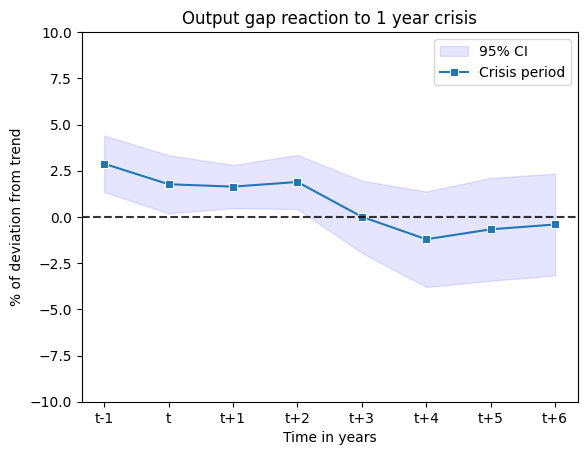

25


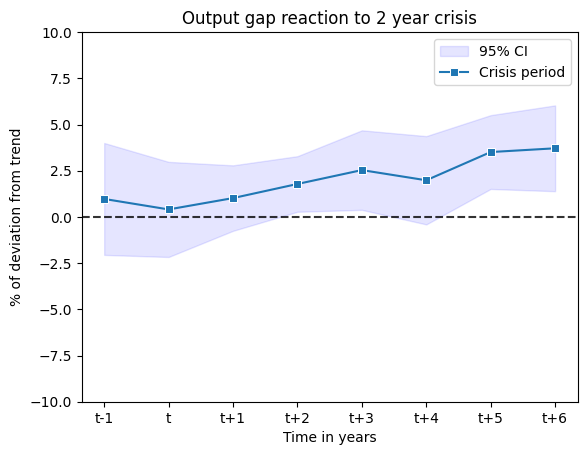

10


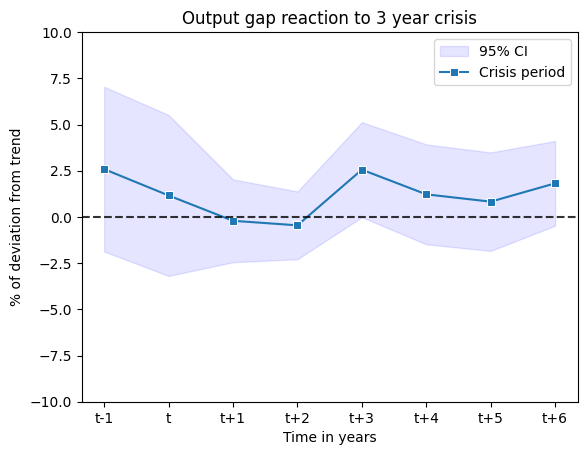

9


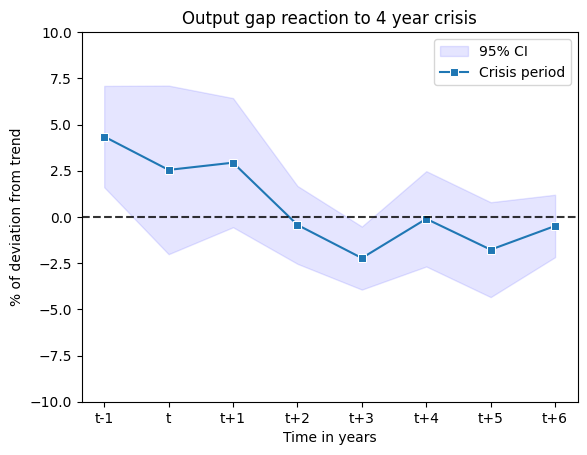

1


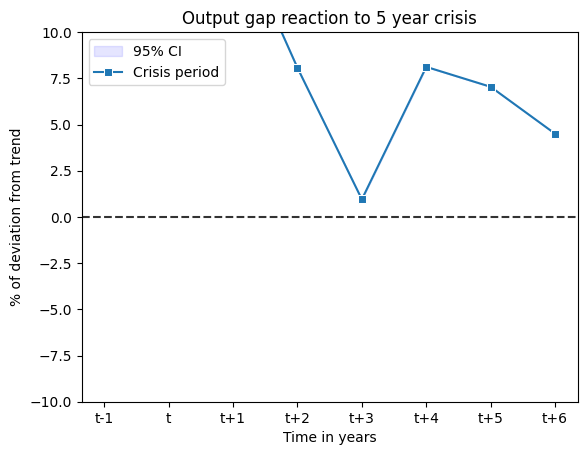

3


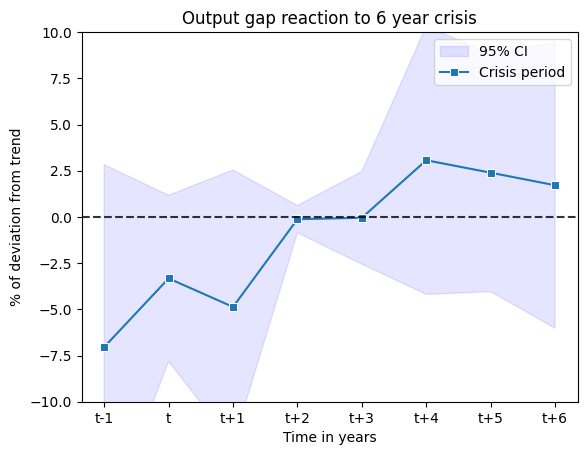

8


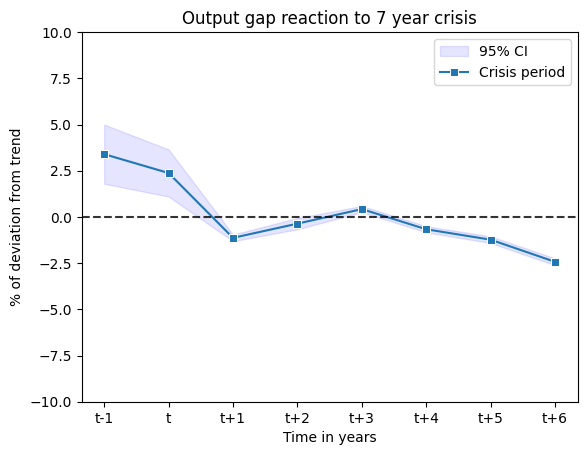

2


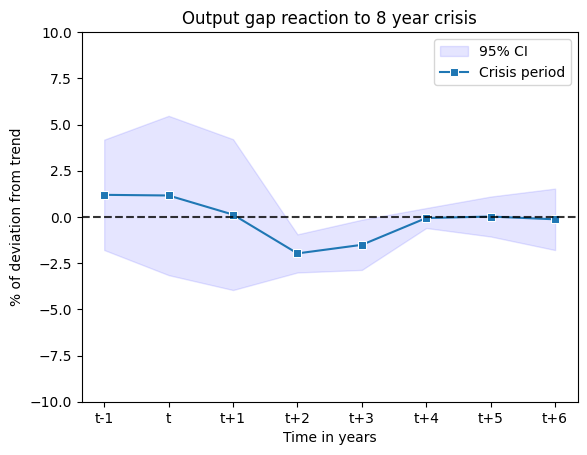

1


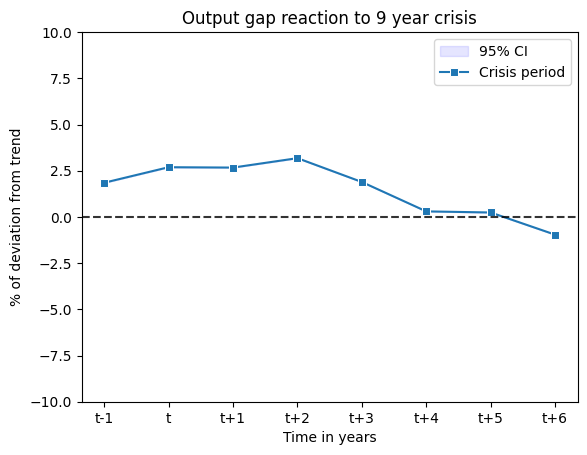

1


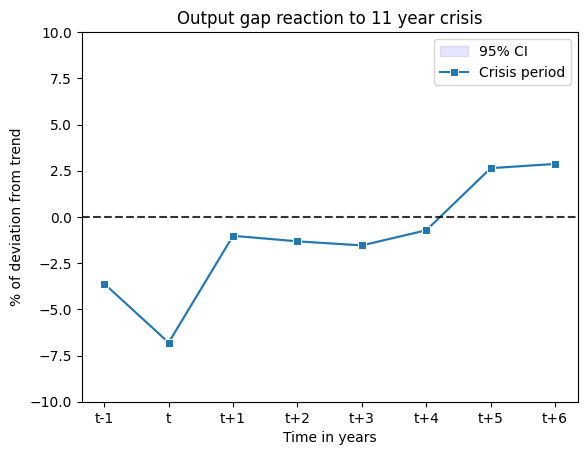

In [582]:
for i in len_freq.Length:
    series_by_crisis_length = []
    #Appending the series for single year crisis
    for j in range (0,len(output_gap_series)):
        if crisis_duration[j] == i:
            series_by_crisis_length.append(output_gap_series[j])
    series_by_crisis_length = np.array(series_by_crisis_length)
    print(len(series_by_crisis_length))

    average_pattern = np.mean(series_by_crisis_length, axis=0)
    confidence_interval = 1.96 * np.std(series_by_crisis_length, axis=0) / np.sqrt(series_by_crisis_length.shape[0])

    years = [f"t{k}" if k < 0 else f"t+{k}" if k > 0 else "t" for k in range(-1, len(average_pattern) - 1)]

    plt.fill_between(
        range(len(average_pattern)),
        average_pattern - confidence_interval,
        average_pattern + confidence_interval,
        color='blue',
        alpha=0.1, label='95% CI'
    )

    sns.lineplot(x = years, y = average_pattern, marker = 's', label = 'Crisis period')
    plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.8)

    plt.title(f'Output gap reaction to {i} year crisis')

    plt.xlabel('Time in years')
    plt.ylabel('% of deviation from trend')
    plt.ylim(-10,10)

    plt.show()

# 4. Crisis & recovery Dynamics in a multiple country database

In [583]:
def crisis_data(data, during_crisis=True):

    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''

    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['annual_inflation']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'annual_inflation'])
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['banking_crisis'] == 0:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

In [584]:
def normalize_crisis_data(list):
    normalized_list = []
    for sublist in list:
        first_element = sublist[0]
        normalized_sublist = [value - first_element for value in sublist]
        normalized_list.append(normalized_sublist)
    return normalized_list

In [585]:
def compute_pattern(list):
    max_length = max(len(sublist) for sublist in list)

    # Initialize an array for the average pattern
    pattern = np.zeros(max_length)

    # Iterate through each position in the pattern
    for i in range(max_length):
        # Initialize variables for the sum and length for each position
        col_sum = 0
        length = 0

        # Iterate through each sublist
        for sublist in list:
            # Check if the current sublist has a value at the current position
            if i < len(sublist):
                col_sum += sublist[i]
                length += 1

        # Calculate the mean for the current position
        mean = col_sum / length if length > 0 else 0

        # Set the mean in the average pattern array
        pattern[i] = mean


    return pattern

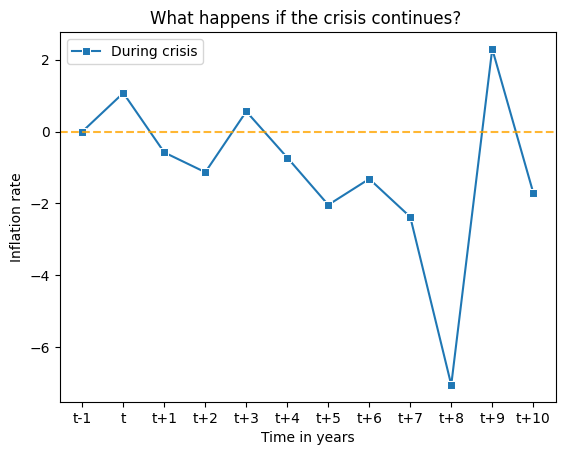

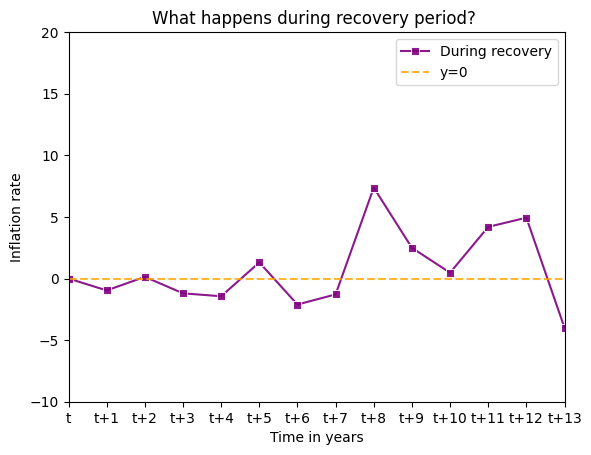

In [586]:
#Compute the average response pattern by time elapsed
pattern_during_crisis = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = True)))
pattern_during_recovery = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = False)))

#Plot the inflation rate during banking crsis period
years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'During crisis')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens if the crisis continues? ')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')

plt.show()

#Plot the inflation rate during recovery period
years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'During recovery')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens during recovery period? ')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')
plt.ylim(-10, 20)
plt.xlim('t', 't+13')
plt.legend()

plt.show()

In [587]:
def output_crisis_data(data, during_crisis=True):
    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''
    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['output_gap']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'output_gap'])
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['banking_crisis'] == 0:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

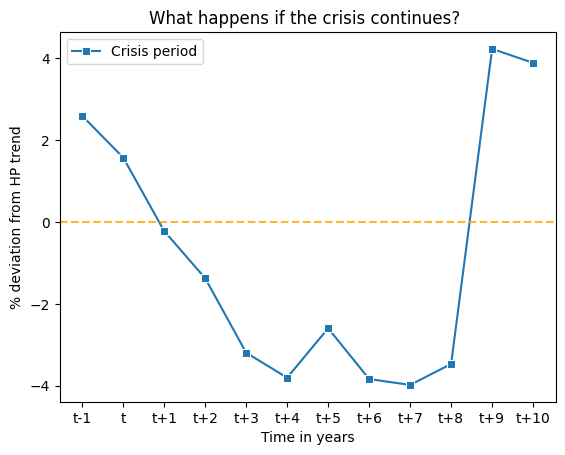

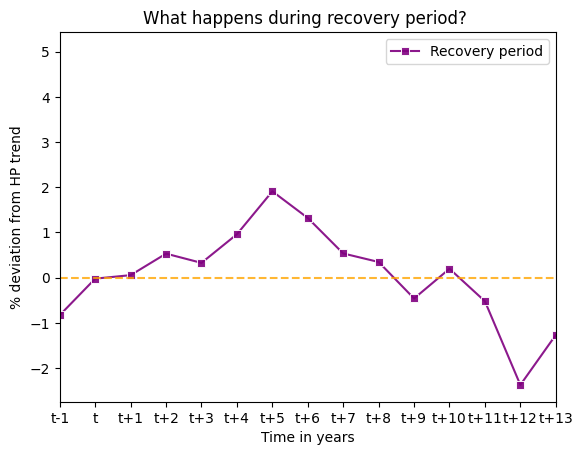

In [590]:
pattern_during_crisis = compute_pattern(output_crisis_data(global_data_inner, during_crisis = True))
pattern_during_recovery = compute_pattern(output_crisis_data(global_data_inner, during_crisis = False))

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'Crisis period')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens if the crisis continues? ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')

plt.show()

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_recovery) - 1)]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'Recovery period')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens during recovery period? ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')
plt.xlim('t-1', 't+13')

plt.show()